In [42]:


# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV into a DataFrame
csv_comms_file_path = 'C:/Users/Contractor/Workspace/CyMARL/pycomm/results/confidentiality_small/comms/0.csv'
df_comms = pd.read_csv(csv_comms_file_path, skiprows=1)

csv_no_comms_file_path = 'C:/Users/Contractor/Workspace/CyMARL/pycomm/results/confidentiality_small/no_comms/0.csv'
df_no_comms = pd.read_csv(csv_no_comms_file_path, skiprows=1)

#df_comms_train = df_comms[(df_comms['Train_Episode'] != 0) | (df_comms['Train_Reward'] != 0)].copy()
df_comms_test = df_comms[(df_comms['Test_Episode'] != 0) | (df_comms['Test_Reward'] != 0)].copy()

#df_no_comms_train = df_no_comms[(df_no_comms['Train_Episode'] != 0) | (df_no_comms['Train_Reward'] != 0)].copy()
df_no_comms_test = df_no_comms[(df_no_comms['Test_Episode'] != 0) | (df_no_comms['Test_Reward'] != 0)].copy()

# Calculate total timesteps for each episode
timesteps_per_episode = 32 * 30

# Calculate rolling average of rewards
window_size = 50  # You can adjust this parameter for the desired smoothing effect

#df_comms_train['Mean_Train_Reward'] = df_comms_train['Train_Reward'].rolling(window=window_size).mean()
df_comms_test['Mean_Test_Reward'] = df_comms_test['Test_Reward'].rolling(window=window_size).mean()

#df_no_comms_train['Mean_Train_Reward'] = df_no_comms_train['Train_Reward'].rolling(window=window_size).mean()
df_no_comms_test['Mean_Test_Reward'] = df_no_comms_test['Test_Reward'].rolling(window=window_size).mean()


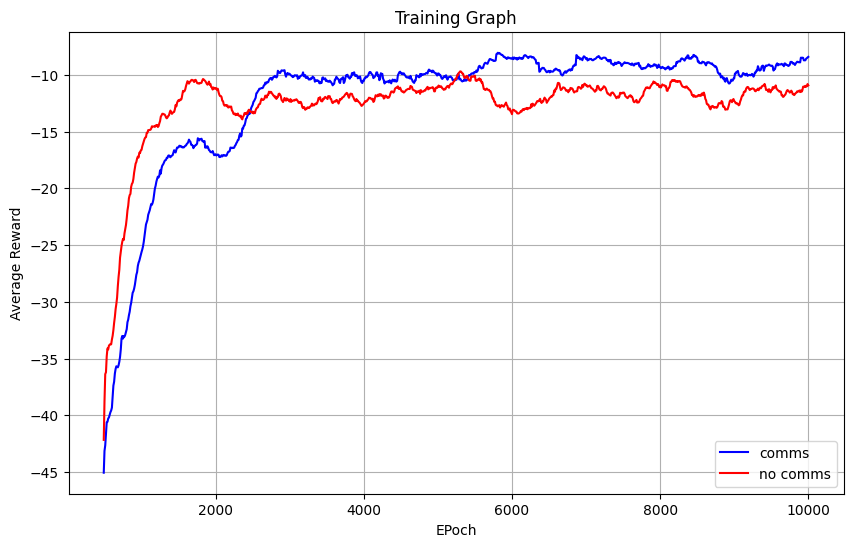

In [43]:
# Plot episode vs reward
plt.figure(figsize=(10, 6))
plt.plot(df_comms_test['Test_Episode'], df_comms_test['Mean_Test_Reward'], linestyle='-', label='comms', color='blue')
plt.plot(df_no_comms_test['Test_Episode'], df_no_comms_test['Mean_Test_Reward'], linestyle='-', label='no comms', color='red')
plt.legend()
plt.title('Training Graph')
plt.xlabel('EPoch')
plt.ylabel('Average Reward')
plt.grid(True)
plt.show()

In [83]:
import ast  # For safely evaluating the string representation of lists

# Mapping dictionary for criteria
mapping = {
    (0, 0, 0): 'Not',
    (1, 0, 1): 'Just Exploited',
    (0, 0, 1): 'User',
    (0, 1, 0): 'Unknown',
    (0, 1, 1): 'Privileged',
}

# Function to apply mapping
def apply_mapping(sublist):
    return [mapping.get(tuple(item), item) for item in sublist]

# Function to parse a line and return a dictionary
def parse_line(line):
    data = {}
    if "Message sent:" in line:
        data['Message'] = ast.literal_eval(line.split("Message sent:")[1].strip())
        for i in range(len(data['Message'])):
            for j in range(len(data['Message'][i])):
                if data['Message'][i][j] < 0.1:
                    data['Message'][i][j] = 0.0
    elif "Action:" in line:
        data['Action'] = ast.literal_eval(line.split("Action:")[1].strip())
    elif "State:" in line:
        state = ast.literal_eval(line.split("State:")[1].strip())
        t_state = [[state[i][j:j+3] for j in range(0, len(state[i]), 3)] for i in range(len(state))]
        data['State'] = [apply_mapping(sublist) for sublist in t_state]
        #data['State'] = [[state[i][j:j+3] for j in range(0, len(state[i]), 3)] for i in range(len(state))]
    return data

# Read the file and create a list of dictionaries for each game
current_game = []
turn = {}
games_data = []

with open('C:/Users/Contractor/Workspace/CyMARL/pycomm/results/confidentiality_small/comms/0.txt', 'r') as file:
    for line in file:
        if '---- Turn 0 ----' in line:
            # Starting a new game
            if current_game:
                current_game = []
                turn = {}
        else:
            if 'State' in line:
                if turn:
                    current_game.append(turn)
                    turn = {}
                    turn.update(parse_line(line))
                else:
                    turn.update(parse_line(line))
            else:
                if 'Total Reward' in line:
                    current_game.append(turn)
                    games_data.append(current_game)
                else:
                    turn.update(parse_line(line))

In [84]:
import matplotlib.pyplot as plt
import numpy as np
# Extract relevant information
agent_messages = []  # List to store messages sent by each agent
for game_data in games_data:
    for timestep_data in game_data:
        agent_messages.append(timestep_data['Message'])

# Convert the list of messages to a flattened NumPy array for plotting
flat_messages = np.concatenate(agent_messages)

#print(flat_messages)

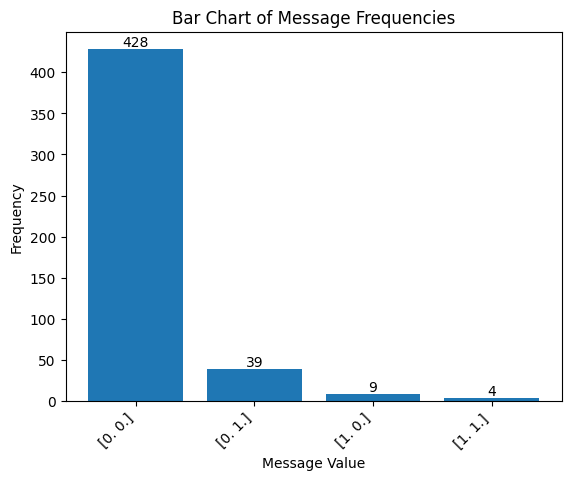

In [85]:
# Count occurrences of each unique message pair
unique_messages, counts = np.unique(flat_messages, axis=0, return_counts=True)

# Plotting bar chart for message frequencies with annotations
fig, ax = plt.subplots()
bars = ax.bar(range(len(unique_messages)), counts, tick_label=[str(pair) for pair in unique_messages])
ax.set_xlabel('Message Value')
ax.set_ylabel('Frequency')
ax.set_title('Bar Chart of Message Frequencies')
ax.set_xticks(range(len(unique_messages)))  # Set tick positions
ax.set_xticklabels([str(pair) for pair in unique_messages], rotation=45, ha='right')  # Set tick labels with rotation
ax.tick_params(axis='x', labelrotation=45)

# Adding text annotations for each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

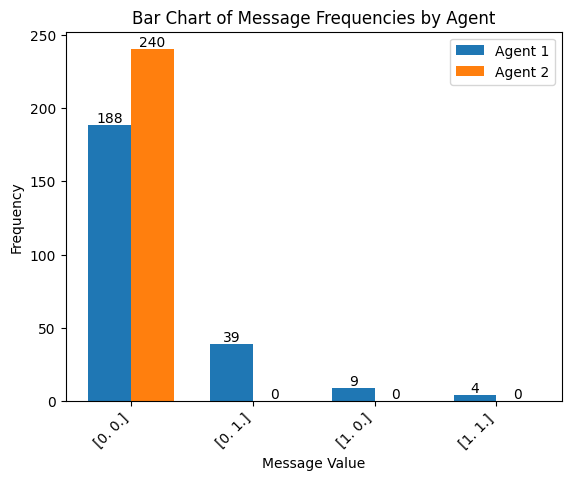

In [86]:
# Separate messages for Agent 1 and Agent 2
messages_agent1 = flat_messages[::2]  # Select every other element starting from the first
messages_agent2 = flat_messages[1::2]  # Select every other element starting from the second

# Count occurrences of each unique message pair for each agent
unique_messages_agent1, counts_agent1 = np.unique(messages_agent1, axis=0, return_counts=True)
unique_messages_agent2, counts_agent2 = np.unique(messages_agent2, axis=0, return_counts=True)

# Ensure both counts arrays have the same length
max_len = max(len(counts_agent1), len(counts_agent2))
counts_agent1 = np.pad(counts_agent1, (0, max_len - len(counts_agent1)))
counts_agent2 = np.pad(counts_agent2, (0, max_len - len(counts_agent2)))

# Set up the positions for side-by-side bars
bar_width = 0.35
index = np.arange(max_len)

# Plotting side-by-side bar chart for message frequencies with annotations
fig, ax = plt.subplots()
bars1 = ax.bar(index - bar_width / 2, counts_agent1, bar_width, label='Agent 1')
bars2 = ax.bar(index + bar_width / 2, counts_agent2, bar_width, label='Agent 2')
ax.set_xlabel('Message Value')
ax.set_ylabel('Frequency')
ax.set_title('Bar Chart of Message Frequencies by Agent')
ax.set_xticks(index)
ax.set_xticklabels([str(pair) for pair in unique_messages_agent1], rotation=45, ha='right')
ax.legend()

# Adding text annotations for each bar (Agent 1)
for bar, count in zip(bars1, counts_agent1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

# Adding text annotations for each bar (Agent 2)
for bar, count in zip(bars2, counts_agent2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

In [87]:
import seaborn as sns

# Extract relevant information
state = []  # List to store tuples of state and message frequency
for game_data in games_data:
    for timestep_data in game_data:
        state.append(timestep_data['State'])

flat_states = np.concatenate(state)

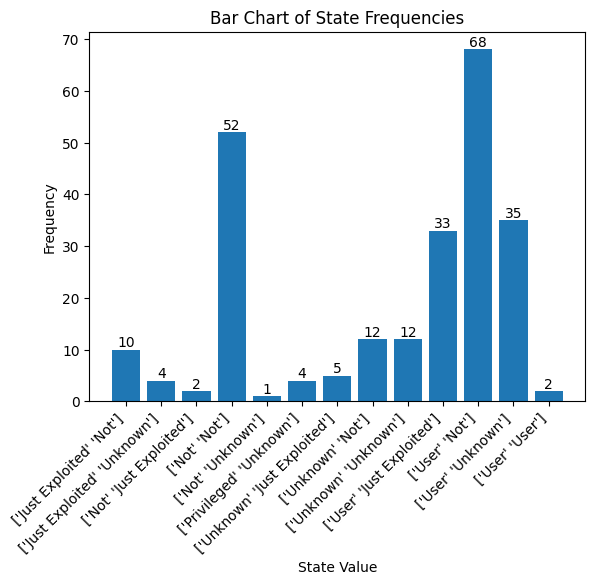

In [88]:
states_agent1 = flat_states[::2]  # Select every other element starting from the first

unique_states_agent1, counts_states_agent1 = np.unique(states_agent1, axis=0, return_counts=True)

# Plotting bar chart for message frequencies with annotations
fig, ax = plt.subplots()
bars = ax.bar(range(len(unique_states_agent1)), counts_states_agent1, tick_label=[str(pair) for pair in unique_states_agent1])
ax.set_xlabel('State Value')
ax.set_ylabel('Frequency')
ax.set_title('Bar Chart of State Frequencies')
ax.set_xticks(range(len(unique_states_agent1)))  # Set tick positions
ax.set_xticklabels([str(pair) for pair in unique_states_agent1], rotation=45, ha='right')  # Set tick labels with rotation
ax.tick_params(axis='x', labelrotation=45)

# Adding text annotations for each bar
for bar, count in zip(bars, counts_states_agent1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{count}', ha='center', va='bottom')

plt.show()

Counter({(('User', 'Not'), (0.0, 0.0)): 55, (('Not', 'Not'), (0.0, 0.0)): 52, (('User', 'Just Exploited'), (0.0, 0.0)): 30, (('User', 'Unknown'), (0.0, 1.0)): 18, (('User', 'Unknown'), (0.0, 0.0)): 17, (('Unknown', 'Not'), (0.0, 0.0)): 12, (('Unknown', 'Unknown'), (0.0, 1.0)): 10, (('Just Exploited', 'Not'), (0.0, 0.0)): 9, (('User', 'Not'), (1.0, 0.0)): 6, (('User', 'Not'), (0.0, 1.0)): 5, (('Unknown', 'Just Exploited'), (0.0, 0.0)): 4, (('Privileged', 'Unknown'), (0.0, 0.0)): 3, (('User', 'Not'), (1.0, 1.0)): 2, (('Unknown', 'Unknown'), (0.0, 0.0)): 2, (('Not', 'Just Exploited'), (0.0, 0.0)): 2, (('Just Exploited', 'Unknown'), (0.0, 1.0)): 2, (('User', 'Just Exploited'), (0.0, 1.0)): 2, (('User', 'Just Exploited'), (1.0, 1.0)): 1, (('User', 'User'), (1.0, 0.0)): 1, (('Privileged', 'Unknown'), (1.0, 0.0)): 1, (('Unknown', 'Just Exploited'), (1.0, 0.0)): 1, (('Just Exploited', 'Unknown'), (0.0, 0.0)): 1, (('User', 'User'), (0.0, 0.0)): 1, (('Just Exploited', 'Not'), (0.0, 1.0)): 1, (('

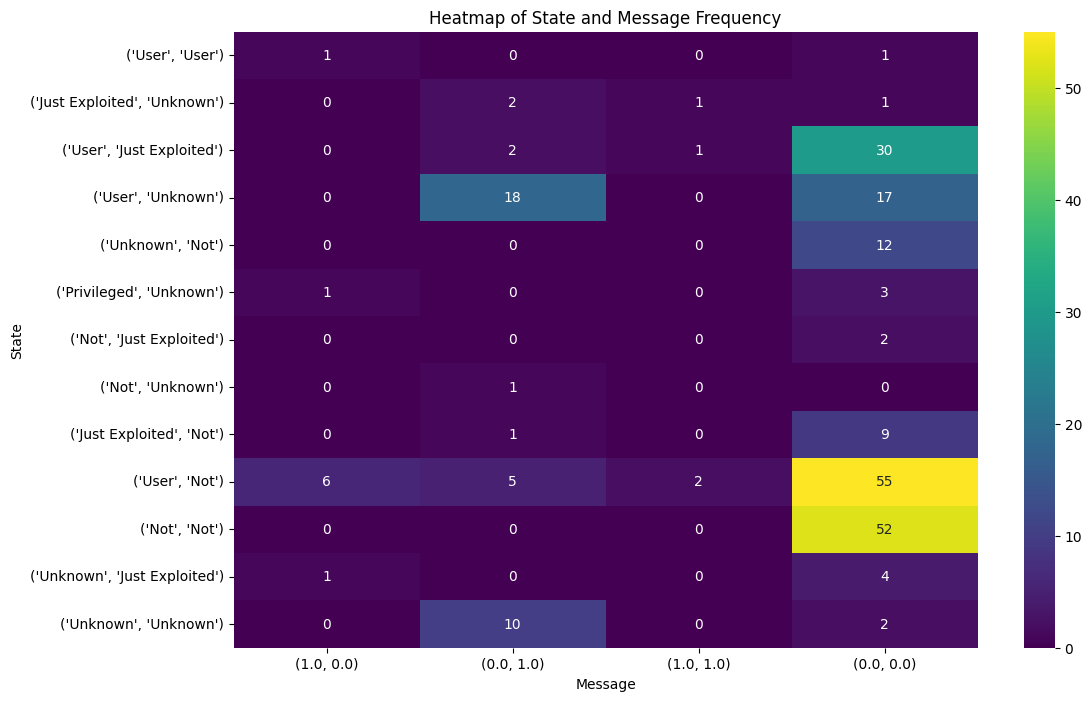

In [112]:
import seaborn as sns
from collections import Counter

# Extract relevant information
states = []  # List to store tuples of state and message frequency
messages = []
for game_data in games_data:
    for timestep_data in game_data:
        states.append(timestep_data['State'])
        messages.append(timestep_data['Message'])

# Convert inner lists to tuples
states_agent_1 = [tuple(sublist[0]) for sublist in states]
messages_agent_1 = [tuple(sublist[0]) for sublist in messages]

# Create a list of tuples combining states and messages
state_message_pairs = list(zip(states_agent_1, messages_agent_1))

# Count occurrences of each unique state and message pair
pair_counter = Counter(state_message_pairs)
print(pair_counter)

# Get unique states and messages directly from the tuples
unique_states = list(set(states_agent_1))
unique_messages = list(set(messages_agent_1))
print(unique_states)
print(unique_messages)

# Create a 2D array to represent the frequency of messages for each state
heatmap_data = [[pair_counter[(state, message)] for message in unique_messages] for state in unique_states]
print(heatmap_data)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, xticklabels=[str(pair) for pair in unique_messages], yticklabels=[str(pair) for pair in unique_states], annot=True, cmap='viridis', cbar=True)

plt.xlabel('Message')
plt.ylabel('State')
plt.title('Heatmap of State and Message Frequency')
plt.show()